# XML檔案為階層格式，用find方式去一層一層找資料

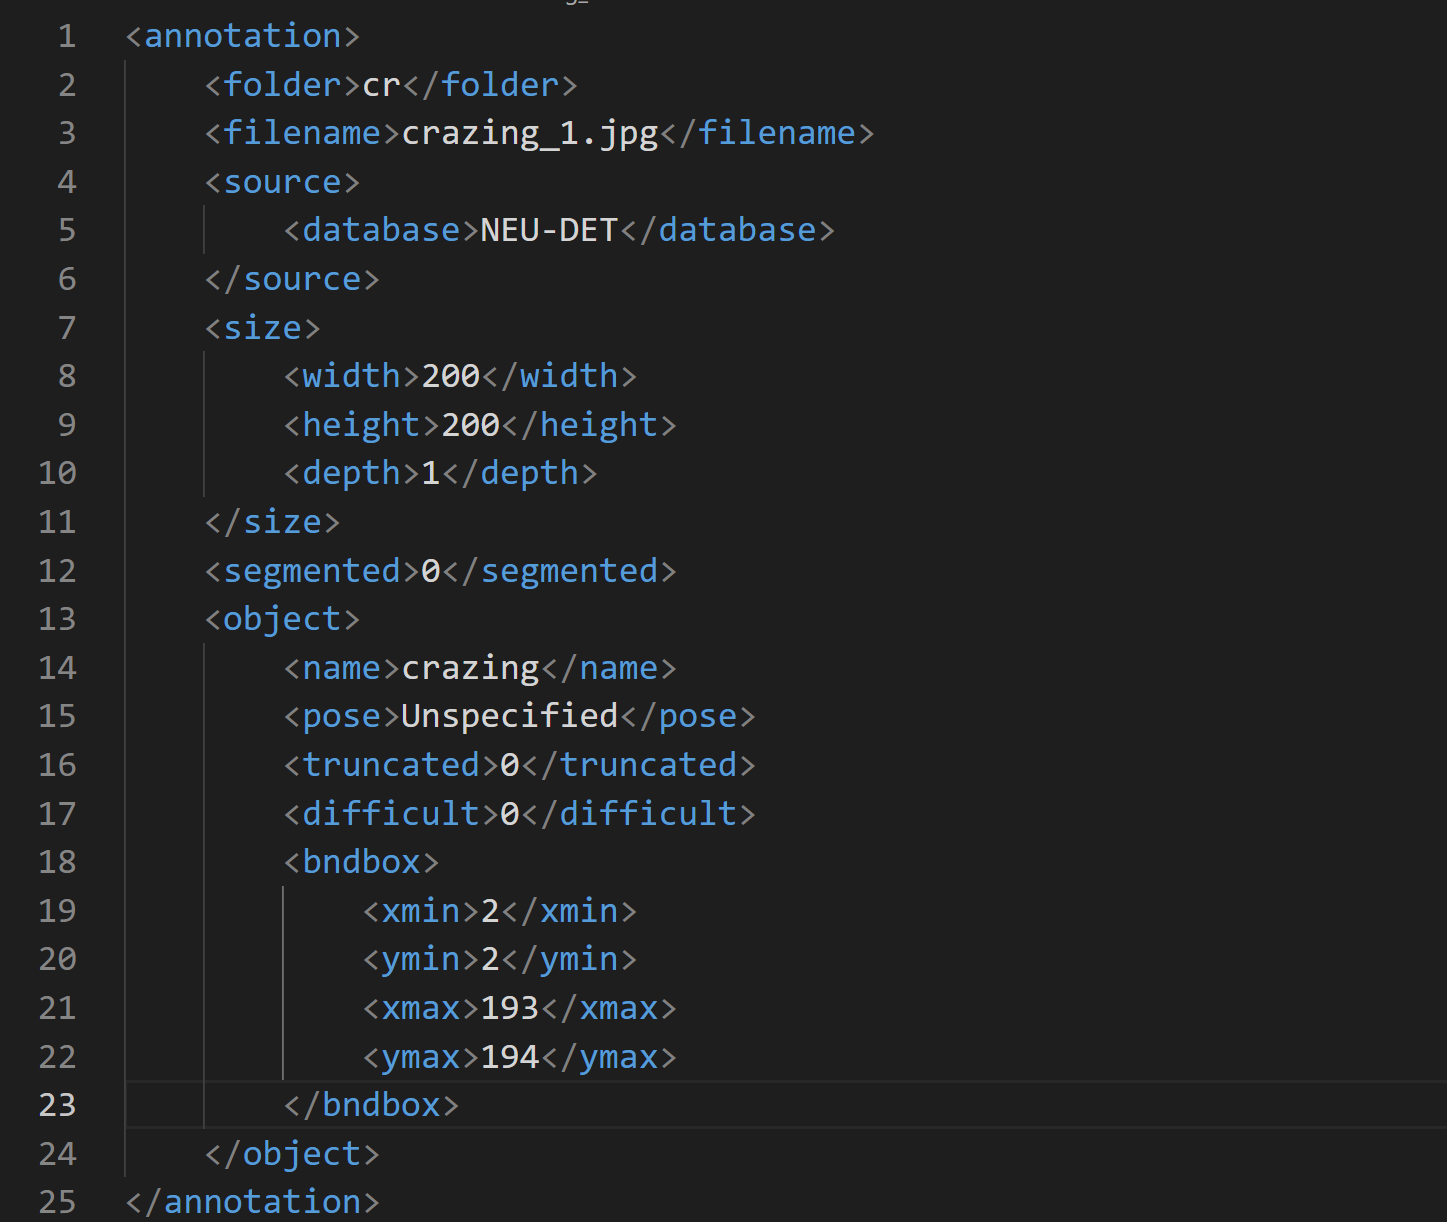

# XML讀取範例

In [2]:
import xml.etree.ElementTree as ET
import os

In [5]:
annotation = "D:/Dataset/NEU-DET/ANNOTATIONS/crazing_1.xml"
root = ET.parse(annotation).getroot()
w = root.find('size/width').text
h = root.find('size/height').text
size = [int(w), int(h)]
for object_xml in root.iter('object'):  # 可能出現一張圖片多個標籤和bounding box
    label = object_xml.find('name').text.lower()
    xmin = object_xml.find('bndbox/xmin').text.lower()
    ymin = object_xml.find('bndbox/ymin').text.lower()
    xmax = object_xml.find('bndbox/xmax').text.lower()
    ymax = object_xml.find('bndbox/ymax').text.lower()
print(f"w = {w}, h = {h}")
print(f"bbox = {xmin}, {ymin}, {xmax}, {ymax}")

w = 200, h = 200
bbox = 2, 2, 193, 194


# YOLO標籤格式為: 類別, x, y, w ,h(正規化)
# XML標籤格式為: xmin, ymin, xmax, ymax(非正規化)

In [6]:
def convert(size, box):
    """
    xmin, xmax, ymin, ymax  --> x, y, w, h(正規化)
    size: w, h  原影像的高寬
    box: [xmin, xmax, ymin, ymax]
    """
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    # x = (xmin + xmax)/2w, x座標除以圖片寬度
    x = x*dw  
    w = w*dw
    y = y*dh
    h = h*dh
    return (x, y, w, h)

In [7]:
def convert_annotation(image_name, classes, path=""):
    """
    讀取物件偵測xml標籤檔案並轉換成yolo的訓練格式(txt, xywh)
    """
    annotation = os.path.join(path, 'ANNOTATIONS', image_name[:-3] + 'xml')  # image_name.jpg to image_name.xml
    labels_path = os.path.join(path, 'LABELS', image_name[:-3] + 'txt')  # LABELS/image_name.txt
    out_file = open(labels_path, 'w')
    root = ET.parse(annotation).getroot()
    w = root.find('size/width').text
    h = root.find('size/height').text
    size = [int(w), int(h)]
    for object_xml in root.iter('object'):  # 可能出現一張圖片多個標籤和bounding box
        label = object_xml.find('name').text.lower()
        label_id = classes.index(label)
        if label not in classes:
            print(f"不存在的標籤: {label}")
            continue
        xmin = object_xml.find('bndbox/xmin').text.lower()
        ymin = object_xml.find('bndbox/ymin').text.lower()
        xmax = object_xml.find('bndbox/xmax').text.lower()
        ymax = object_xml.find('bndbox/ymax').text.lower()
        xyxy = [float(xmin), float(ymin), float(xmax), float(ymax)]
        bbox = convert(size, xyxy)  # w, h, xyxy
        labetext = str(label_id) + " " + " ".join([str(a) for a in bbox]) + '\n'
        out_file.write(labetext)
    out_file.close()

In [8]:
def xml_to_yolo(classes, root_path=""):
    IMAGES = os.path.join(root_path, "IMAGES")
    LABELS = os.path.join(root_path, "LABELS")
    if not os.path.exists(LABELS):
        os.mkdir(LABELS)

    for image_name in os.listdir(IMAGES):
        convert_annotation(image_name, classes=classes, path=root_path)
    print("Done")

# 先將資料夾整理成這種形式即可使用

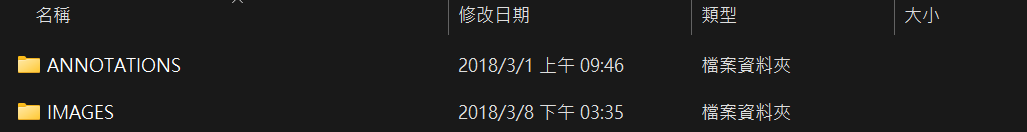

In [9]:
classes = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]
xml_to_yolo(classes, root_path="D:/Dataset/NEU-DET")

Done
